![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
## Welcome to The QuantConnect Research Page
#### Refer to this page for documentation https://www.quantconnect.com/docs#Introduction-to-Jupyter
#### Contribute to this template file https://github.com/QuantConnect/Lean/blob/master/Jupyter/BasicQuantBookTemplate.ipynb

In [1]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Data.Consolidators import QuoteBarConsolidator
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from QuantConnect.Indicators.CandlestickPatterns import *
from datetime import datetime, timedelta
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import pdb

In [1]:
class Agent:
    
    def __init__(self, barsPerSequence, resolution = Resolution.Hour):
        self.barsPerSequence = 24
        self.environment = Environment(barsPerSequence, resolution)
        self.batchSize = 48
        self.numInputSignals = 4
        self.numActions = self.environment.getNumberOfActions()
        self.inputs = None
        self.targetNet = None
        self.qNet = None
        
        self.learningRate = 0.01
        
    def initNetworks(self):
        
        tf.reset_default_graph()
        self.inputs = tf.placeholder(tf.float32, [None, self.barsPerSequence, self.numInputSignals])
        self.qNet = DeepQNet(self.inputs, self.numActions, 'QNet')
        self.qNet.buildNetwork()
        self.targetNet = DeepQNet(self.inputs, self.numActions, 'TargetNet')
        self.targetNet.buildNetwork()
    
    def defineOptimization(self):
        
        self.actionPerformed = tf.placeholder(tf.int32, shape = (None,))
        qValuePrediction = tf.reduce_sum( self.targetNet.output * tf.one_hot(self.actionPerformed, self.numActions), axis = -1, keep_dims = True )
        self.qValueTarget = tf.placeholder( tf.float32, shape = (None, 1) )
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learningRate)
        self.loss = tf.reduce_mean( tf.square(self.qValueTarget - qValuePrediction) )
        self.trainingOp = optimizer.minimize(self.loss)
    
    def copy_weights_to_target_network(self):
        
        copyOperations = []
        
        for variableName, networkVariable in self.qNet.network_variables.items():
            copyTensor = tf.assign( networkVariable, self.targetNet.network_variables[variableName] )
            copyOperations.append(copyTensor)
        
        tf.group(*copyOperations).run()        
        
class DeepQNet(self, networkInput, numActions, networkName):
    
    def __init__(self):
        self.networkName = networkName
        self.lstmUnits = 16
        self.neuronsFcn1 = 64
        self.numOutputs = numActions
        self.networkInput = networkInput
        self.output = None
        self.networkVariables = None
    
    def buildNetwork(self):
        # 4x16 LSTM --> 16x64 FCN --> ReLu --> 64x7 FCN
        
        with tf.variable_scope(self.networkName) as scope:

            lstmCell = tf.contrib.rnn.LSTMCell(self.lstmUnits)
            wrappedLstmCell = tf.contrib.rnn.DropoutWrapper(cell = lstmCell, output_keep_prob = 0.8)
            outputs, _ = tf.nn.dynamic_rnn(wrappedLstmCell, self.networkInput, dtype = tf.float32)  # shape: [batchSize, sequenceLength, lstmUnits]
            outputs = tf.transpose(outputs, [1, 0, 2]) # shape: [sequenceLength, batchSize, lstmUnits]
            sequenceLength = int( outputs.get_shape()[0] )
            lastSequenceOutputs = tf.gather( outputs, sequenceLength - 1) # returns [batchSize, lstmUnits] of the last sequence sample
            
            weightsInitFcn1 = tf.truncated_normal_initializer( stddev = math.sqrt( 2 / (self.lstmUnits + self.neuronsFcn1) ) )
            biasInitFcn1 = tf.constant_initializer(0.05)
            fcn1 = tf.contrib.layers.fully_connected( lastSequenceOutputs, num_outputs = self.neuronsFcn1, \
                                                     weights_initializer = weightsInitFcn1, biases_initializer = biasInitFcn1)
            
            weightsInitFcn2 = tf.truncated_normal_initializer( stddev = math.sqrt( 2 / (self.neuronsFcn1 + self.numOutputs) ) )
            biasInitFcn2 = tf.constant_initializer(0.05)
            self.output = tf.contrib.layers.fully_connected( fcn1, num_outputs = self.numOutputs, activation_fn = None \
                                                            weights_initializer = weightsInitFcn2, biases_initializer = biasInitFcn2, scope = None )
            
            self.networkVariables = { trainable_var.name[ len(scope.name): ] : trainable_var for trainable_var in tf.trainable_variables(scope=scope.name) }

class Environment:
    ''' Provides the observations, performs the actions and yields the rewards.
    Each time a new episode is started via the reset method, a random forex is selected at a random time,
    given the time boundary conditions and selected portfolio of forex. '''
    
    def __init__(self, barsPerSequence, resolution):
        self.actionSpace = {0: self.observeMarket, 1: self.orderLong, 2: self.orderShort, \
                            3: self.holdLong, 4: self.holdShort, 5: self.closeLong, 6: self.closeShort}
        self.sampler = Sampler(resolution)
        self.barsPerSequence = barsPerSequence
        self.currentSample = None
        self.sampleState = 0 # 0:nothing done yet, 1:executed order, 2: closed order
        self.sampleObservationHistory = []
        self.sampleActionHistory = []
        self.sampleRewardHistory = []
   
    def reset(self):
        # use this method to initialize a new episode
        
        self.openInvest = 0
        self.sampleState = 0
        self.sampleObservationHistory = []
        self.sampleActionHistory = []
        self.sampleRewardHistory = []
        self.currentSample = self.sampler.getSample(self.barsPerSequence)
        self.currentSample.__iter__() # init the iteration
        self.sampleObservationHistory.append( self.currentSample.__next__() )
    
    def step(self, action):
        # each step returns a new observation, reward and information if the episode is done
        
        isDone = self.isSampleDone()
        
        if not isDone:
            try:
                self.actionSpace[action]() # performs the action
                self.sampleObservationHistory.append( self.currentSample.__next__() )
            except StopIteration:
                isDone = True  
                
        return isDone
    
    def getNumberOfActions(self):
        return len(self.actionSpace)
    
    def getSarsSamples(self):
        # returns all the (s,a,r,s')-samples from the last episode
        
        nTransitions = len(self.sampleActionHistory)
        sarsSamples = []
        for i in range(1, nTransitions):
            observation = self.sampleObservationHistory[i-1]
            action = self.sampleActionHistory[i]
            reward = self.sampleRewardHistory[i]
            observationNext = self.sampleObservationHistory[i]
            sarsSamples.append([observation, action, reward, observationNext])
        
        return sarsSamples
    
    def isSampleDone(self):
        return self.sampleState == 2
    
    def observeMarket(self):
        self.sampleActionHistory.append(0)
    
    def orderLong(self):
        invest = self.calcInvest()
        self.cash -= invest
        self.openInvest = invest
        self.sampleActionHistory.append(1)
    
    def orderShort(self):
        invest = self.calcInvest()
        self.cash -= invest
        self.openInvest = invest
        self.sampleActionHistory.append(2)
    
    def holdLong(self):
        self.sampleActionHistory.append(3)
        
    def holdShort(self):
        self.sampleActionHistory.append(4)
        
    def closeLong(self):
        self.sampleActionHistory.append(5)
        self.closePosition()
    
    def closeShort(self):
        self.sampleActionHistory.append(6)
        self.closePosition() 
    
    def closePosition(self):
        rewarder = Rewarder(self.currentSample, 12)
        self.cash += rewarder.getRoi(self.sampleActionHistory)
        self.sampleRewardHistory = rewarder.getRewards(self.sampleActionHistory)
        self.openInvest = 0

class Rewarder:
    # calculates the reward for any action
    
    def __init__(self, dataset, sphereSize):
        self.dataset = dataset
        self.sphereSize = sphereSize # defines how many neighbour bars we observe to estimate the goodness of the action
        self.rewardFunctions = {0: self.rewardObserveMarket, 1: self.rewardOpenLong, 2: self.rewardOpenShort, \
                                3: self.rewardHoldLong, 4: self.rewardHoldShort, 5: self.rewardCloseLong, 6: self.rewardCloseShort}
        self.orderPosition = None
        self.closePosition = None
        self.lengthPositionOpen = None
        self.orderType = None
        
    def getRewards(self, actionHistory):
        
        rewardHistory = []
        self.getOrderAndClosePosition(actionHistory)
        position = self.dataset.numObtainBars - 1 # the start position is the number of obtained bars in the sample
        
        for action in actionHistory:
            rewardFunctionHandle = self.rewardFunctions[action]
            rewardHistory.append( rewardFunctionHandle(position) )
            position += 1
        
        return rewardHistory
        
    def rewardObserveMarket(self, position):
        # calculates the reward for waiting before opening a position
        
        return 0
        
    def rewardOpenLong(self, position):
        # calculates the reward for opening a long position
        # orderPosition and closePosition must be the value dataset returns via the getPosition method
        
        bestOpeningPrice = self.dataset.getPeakPrice("min", self.orderPosition - self.sphereSize, self.closePosition)
        realOpeningPrice = self.dataset.priceAsk[self.orderPosition - 1]
        realClosingPrice = self.dataset.priceBid[self.closePosition - 1]
        
        roi = 100 * (realClosingPrice - realOpeningPrice) / realOpeningPrice
        missedRoi = 100 * (realOpeningPrice - bestOpeningPrice) / realOpeningPrice
        
        reward = (0.5*roi - missedRoi) / self.lengthPositionOpen
        return self.clipRewards(reward)
    
    def rewardOpenShort(self, position):
        # calculates the reward for opening a short position
        # orderPosition and closePosition must be the value dataset returns via the getPosition method  
        
        bestOpeningPrice = self.dataset.getPeakPrice("max", self.orderPosition - self.sphereSize, self.closePosition)
        realOpeningPrice = self.dataset.priceBid[self.orderPosition - 1]
        realClosingPrice = self.dataset.priceAsk[self.closePosition - 1]
        
        roi = -100 * (realClosingPrice - realOpeningPrice) / realOpeningPrice
        missedRoi = -100 * (realOpeningPrice - bestOpeningPrice) / realOpeningPrice
        
        reward = (0.5*roi - missedRoi) * (24/self.lengthPositionOpen)
        return self.clipRewards(reward)  
    
    def rewardHoldLong(self, position):
        # calculates the reward for waiting inside an open long position
        # position must be the value the dataset object returns via the getPosition method
        
        currentSellPrice = self.dataset.priceBid[position - 1]
        bestFutureSellPrice = self.dataset.getPeakPrice("max", position - 1, self.closePosition)
        worstFutureSellPrice = self.dataset.getPeakPrice("min", position - 1, self.closePosition)
        meanFutureSellPrice = (bestFutureSellPrice + worstFutureSellPrice) / 2
        
        reward = 100 * 2 * (meanFutureSellPrice - currentSellPrice) / currentSellPrice  * (24/self.lengthPositionOpen)
        return self.clipRewards(reward)
    
    def rewardHoldShort(self, position):
        # calculates the reward for waiting inside an open long position
        # position must be the value the dataset object returns via the getPosition method
        
        currentBuyPrice = self.dataset.priceAsk[position - 1]
        bestFutureBuyPrice = self.dataset.getPeakPrice("min", position, self.closePosition)
        worstFutureBuyPrice = self.dataset.getPeakPrice("max", position, self.closePosition)
        meanFutureSellPrice = (bestFutureSellPrice + worstFutureSellPrice) / 2
        
        reward = -100 * 2 * (meanFutureSellPrice - currentBuyPrice) / currentBuyPrice  * (24/self.lengthPositionOpen)
        return self.clipRewards(reward) 

    def rewardCloseLong(self, position):
        # calculates the reward for closing a long position
        # orderPosition and closePosition must be the value dataset returns via the getPosition method
        
        bestClosingPrice = self.dataset.getPeakPrice("max", self.orderPosition, self.closePosition + self.sphereSize)
        realClosingPrice = self.dataset.priceBid[self.closePosition -1]
        realOpeningPrice = self.dataset.priceAsk[self.orderPosition - 1]
        
        roi = 100 * (realClosingPrice - realOpeningPrice) / realOpeningPrice
        missedRoi = 100 * (bestClosingPrice - realClosingPrice) / realOpeningPrice
        
        reward = (0.5*roi - missedRoi)  * (24/self.lengthPositionOpen)
        return self.clipRewards(reward)
    
    def rewardCloseShort(self, position):
        # calculates the reward for closing a short position
        # orderPosition and closePosition must be the value dataset returns via the getPosition method    
        
        bestClosingPrice = self.dataset.getPeakPrice("min", self.orderPosition, self.closePosition + self.sphereSize)
        realClosingPrice = self.dataset.priceAsk[self.closePosition -1]
        realOpeningPrice = self.dataset.priceBid[self.orderPosition - 1]
        
        roi = -100 * (realClosingPrice - realOpeningPrice) / realOpeningPrice
        missedRoi = -100 * (bestClosingPrice - realClosingPrice) / realClosingPrice
        
        reward = (0.5*roi - missedRoi)  * (24/self.lengthPositionOpen)
        return self.clipRewards(reward)        
        
    def getRoi(self, actionHistory):
        # calculates the relative return on investment from the action history of the sample
        
        orderPos, closingPos, orderType = self.getOrderAndClosePosition(actionHistory)
        
        if orderType == 1:
            openingPrice = self.dataset.priceAsk[orderPos[0] - 1]
            closingPrice = self.dataset.priceBid[closingPos[0] - 1]
            roi = (closingPrice - openingPrice) / openingPrice
        else:
            openingPrice = self.dataset.priceBid[orderPos[0] - 1]
            closingPrice = self.dataset.priceAsk[closingPos[0] - 1]
            roi = -(closingPrice - openingPrice) / openingPrice
        
        return roi
    
    def getOrderAndClosePosition(self, actionHistory):
        # returns the positions of the order and the close position inside the sample and if the order was a long (1) or short (-1)
        
        actionHistory = np.array(actionHistory)
        
        orderLongPos = np.where(actionHistory == 1)[0].tolist()
        orderShortPos = np.where(actionHistory == 2)[0].tolist()
        closeLongPos = np.where(actionHistory == 5)[0].tolist()
        closeShortPos = np.where(actionHistory == 6)[0].tolist()
        
        orderPos = orderLongPos + orderShortPos
        closingPos = closeLongPos + closeShortPos
        
        orderType = 1 if len(orderLongPos) != 0 else -1
        
        sampleOffset = self.dataset.numObtainBars - 1
        self.orderPosition = orderPos[0] + sampleOffset
        self.closePosition = closingPos[0] + sampleOffset
        self.lengthPositionOpen = self.closePosition - self.orderPosition
        self.orderType = orderType
    
    @staticmethod
    def clipRewards(reward):
        # uses a sigmoid function to clip rewards from -1 to +1
        
        clippedReward = 2 / (1 + np.exp(-14*reward)) - 1
        return clippedReward


class Sampler:
    # returns a random dataset given the boundaries defined in the __init__ method
    
    def __init__(self, resolution):
        if resolution < 2: raise ValueError("Only minute (2), hour (3) and daily (4) data")
        
        self.qb = QuantBook()
        self.forexList = ["EURUSD", "GBPUSD", "USDJPY", "USDCAD", "AUSUSD", "USDCHF", \
                          "NZDUSD", "EURGBP", "EURJPY", "AUDJPY", "GBPJPY", "EURCHF"]
        self.MINIMUM_YEAR = 2008
        self.MAXIMUM_YEAR = 2015
        self.resolution = resolution
        self.MAX_RANDOMIZED_SAMPLE_LENGTH = {2:1440, 3:24, 4:0} # depending on resolution
        self.NUM_SAMPLES = 720
        self.WARUMUP_BUFFER_SAMPLES = 50
        self.DAYS_MONTH = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, \
                           7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
        self.rsi = None
        self.macd = None
        self.standardDeviation = None
        self.adx = None
        self.addTradingObjects()
        self.addIndicators()
        
    def addTradingObjects(self):
        for fxSymbol in self.forexList:
            self.qb.AddForex(fxSymbol)
        
    def addIndicators(self):
        self.rsi = RelativeStrengthIndex(14)
        self.macd = MovingAverageConvergenceDivergence(12, 26, 9)
        self.standardDeviation = StandardDeviation(26)
        self.adx = AverageDirectionalIndex("ADX", 18)
    
    def getSample(self, snapshotLength):
        
        dataNotAvailable = True
        
        while dataNotAvailable:
            forexSymbol = self.getRandomForexSymbol()
            datetimeEnd = self.getRandomDatetime()
            self.qb.SetStartDate(datetimeEnd)
            randomSampleLength = random.randint(0, self.MAX_RANDOMIZED_SAMPLE_LENGTH[self.resolution]) # randomize the sample length to not start at the same time for each sample
            sampleLength = self.NUM_SAMPLES + randomSampleLength
            dataframeLength = sampleLength + self.WARUMUP_BUFFER_SAMPLES
            
            price = self.qb.History([forexSymbol], dataframeLength, self.resolution)
            dataNotAvailable = price.empty
            
        sample = Dataset(sampleLength, snapshotLength)
        sample.setPrice( self.qb.History([forexSymbol], dataframeLength, self.resolution) )
        sample.setRsi( self.qb.Indicator(self.rsi, forexSymbol, dataframeLength, self.resolution) )
        sample.setAdx( self.qb.Indicator(self.adx, forexSymbol, dataframeLength, self.resolution) )
        sample.setMacd( self.qb.Indicator(self.macd, forexSymbol, dataframeLength, self.resolution), \
                       self.qb.Indicator(self.standardDeviation, forexSymbol, dataframeLength, self.resolution) )
        
        return sample
        
    def getRandomForexSymbol(self):
        nSymbols = len(self.forexList)
        randomForexNumber = random.randint(0, nSymbols-1)
        return self.forexList[randomForexNumber]
    
    def getRandomDatetime(self, noMaximumLimitation = False):
        datetimeNow = datetime.now()
        maximumYear = datetimeNow.year if noMaximumLimitation else self.MAXIMUM_YEAR            
        randomYear = random.randint(self.MINIMUM_YEAR, maximumYear)
        randomMonth = random.randint(1, 12) if randomYear != datetimeNow.year else random.randint(1, datetimeNow.month)
        nDaysMonth = self.DAYS_MONTH[randomMonth] if not (self.isLeapYear(randomYear) and randomMonth == 2) else 29
        randomDay = random.randint(1, nDaysMonth)
        
        randomDatetime = datetime(randomYear, randomMonth, randomDay)
        latestDatetime = datetimeNow
        return min(randomDatetime, latestDatetime)
    
    def getSamplesRangeTimedelta(self):
        resolutionMinutes = self.RESOLUTION_MINUTES[self.resolution]
        minimumMinutes = resolutionMinutes * (self.NUM_SAMPLES + self.WARUMUP_BUFFER_SAMPLES)
        return timedelta(minutes = minimumMinutes)
    
    @staticmethod
    def isLeapYear(year):
        return True if year % 4 == 0 else False

class Dataset:
    ''' 
    The Dataset class is a wrapper for a data sample. Once the required dataframes are set,
    we can loop through the data, revealing us a snapshot of the last observed datapoints.
    The amount of datapoints revealed in one snapshot can be adjusted with the variable numObtainBars.
    Every step we iterate over a dataset the window steps one datapoint forward (as in a queue).
    '''
    
    def __init__(self, numBars, numObtainBars):
        self.length = numBars # defines how many bars with the beginning of the last datapoint we'll ingest from the dataframes
        self.numObtainBars = numObtainBars # defines how many last bars we should return when the iterator is called
        self.priceAsk = []
        self.priceBid = []
        self.rsi = []
        self.macdLine = []
        self.macdHistogram = []
        self.adx = []
        self.iterPosition = 0
        
    def __iter__(self):
        self.iterPosition = self.numObtainBars - 1
        return self
    
    def __next__(self):
        self.iterPosition += 1
        if self.iterPosition > self.length: raise StopIteration 

        startPoint = self.iterPosition - self.numObtainBars
        endPoint = self.iterPosition
        snapshot = self.createSnapshot(startPoint, endPoint)
        return snapshot
    
    def getPosition(self):
        return self.iterPosition
    
    def getPeakPrice(self, maxMin, startPoint, endPoint):
        # returns the maximum bid price / minimum ask price with respect to the referencePoint to the next <deltaBars> samples
                
        if maxMin == "min":
            return min( self.priceAsk[startPoint:endPoint] )
        elif maxMin == "max":
            return max( self.priceBid[startPoint:endPoint] )
        else:
            raise ValueError("maxMin must be defined by codewords max or min")
    
    def createSnapshot(self, startPoint, endPoint):
        snapshot = [ self.rsi[startPoint:endPoint], self.macdLine[startPoint:endPoint], \
                    self.macdHistogram[startPoint:endPoint], self.adx[startPoint:endPoint] ]         
        return snapshot
    
    def setPrice(self, priceDataframe):
        self.priceAsk = priceDataframe['askclose'].values[-self.length:]
        self.priceBid = priceDataframe['bidclose'].values[-self.length:]
    
    def setRsi(self, rsiDataframe):
        self.rsi = rsiDataframe['relativestrengthindex'].values[-self.length:]
    
    def setAdx(self, adxDataframe):
        self.adx = adxDataframe['averagedirectionalindex'].values[-self.length:]
    
    def setMacd(self, macdDataframe, stddevDataframe):
        macdLine = macdDataframe['movingaverageconvergencedivergence'].values[-self.length:]
        macdHistogram = macdDataframe['histogram'].values[-self.length:]
        standardDeviation = stddevDataframe['standarddeviation'].values[-self.length:]
        self.macdLine = [macd/stddev for macd, stddev in zip(macdLine, standardDeviation)] # norm the data due to comparison between different price levels
        self.macdHistogram = [histogram/stddev for histogram, stddev in zip(macdHistogram, standardDeviation)] # norm the data due to comparison between different price levels        

IndentationError: expected an indented block (<ipython-input-1-274e3e6e65e5>, line 46)

Text(0.5, 1.0, 'rewards')

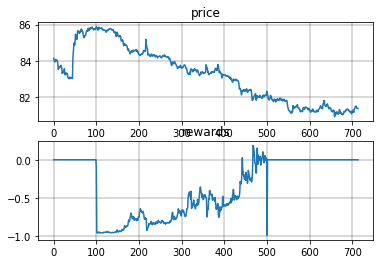

In [4]:
sampler = Sampler(Resolution.Hour)
sample = sampler.getSample(24)

rewarder = Rewarder(sample, 12)
actionHistory = [0]*100 + [1] + [3]*399 + [5]
rewardHistory = rewarder.getRewards(actionHistory)

plt.subplot(2, 1, 1)
plt.plot(sample.priceAsk[24:])
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.title('price')

plt.subplot(2, 1, 2)
plt.plot( rewardHistory + [0] * ( len(sample.priceAsk[24:]) - len(rewardHistory) ) )
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.title('rewards')